In [6]:
using Revise

## Overview

- We need to show "preliminary results" for 11th may.

- Then we will have another 2-3 weeks to work on the final results.

- Results for last year's benchmarks -- but run with the current versions of the packages (see below) -- are done:

    - [Van der Pol benchmark](https://github.com/mforets/escritoire/blob/master/2020/Week16/VanDerPol_ARCH-COMP2020.ipynb)
    - [Laub-loomis benchmark](https://github.com/mforets/escritoire/blob/master/2020/Week16/Laub-Loomis_ARCH-COMP2020.ipynb)
    - [Quadrotor benchmark](https://github.com/mforets/escritoire/blob/master/2020/Week16/Quadrotor_ARCH-COMP2020.ipynb)

- Among these, two models have been extended this year:

    - [Quadrotor with larger initial sets](https://github.com/mforets/escritoire/blob/master/2020/Week19/Quadrotor_ARCH-COMP2020_new.ipynb).
        - Seems to work quite well.

    - [Coupled der Pol oscillator](https://github.com/mforets/escritoire/blob/master/2020/Week18/CoupledVanDerPol2.ipynb)
        - The hardest scenario is the stiff $\mu = 2$ case. We were able to validate that $y \leq \beta$ is safe for $\beta \geq 4.05$. However, it remains to see if we can prove smaller $\beta$ and if there is a better choice of the partition of the initial sets, or another strategy, such as partitionining in the intermediate computations and recomputing from that point.

- Last year we were not able to handle the hybrid model (Space rendez-vous) This is one of the goals of this year. Moreover, this year this model is extended for non-deterministic time guards.

- Finally, there are two new models this year:

    - Production-destruction system (Michaelis-Menten).
    - Lotka-Volterra with a tangential crossing.

- There is a [Trello board with some open tasks](https://trello.com/b/QQEIjTmW/arch-comp2020-nln).

## Workflow

- New package [ReachabilityAnalysis.jl](https://github.com/JuliaReach/ReachabilityAnalysis.jl).
    - Defines a common `solve` interface to solve reachability problems, for purely continuous (linear and nonlinear) and for hybrid systems.
    - Inspired by the `DifferentialEquations.jl` user interface.
    - It is already registered in the general registry. However it's still under heavy development :)
    - [Documentation is in progress](https://juliareach.github.io/ReachabilityAnalysis.jl/dev/introduction/#Introduction-1).
    - We plan to add a library of example models (`ReachabilityModels.jl`) using Literate.jl to exhibit both documentation style and executable jupyter notebooks on the cloud.
    - A library of reachability benchmarks (`ReachabilityBenchmarks`) exists and we have used it for previous papers, however, we still need to adapt it to the new `ReachabiliyAnalis.jl` interface.

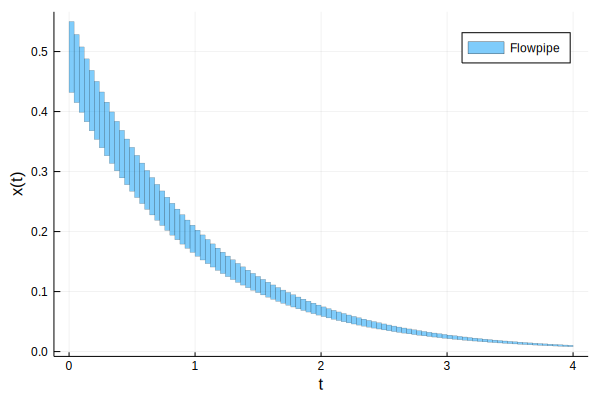

In [7]:
using ReachabilityAnalysis, Plots

# define the initial-value problem
# x' = Ax + Bu, x ∈ X, u ∈ U, x(0) ∈ X0
prob = @ivp(x' = -x, x(0) ∈ 0.45 .. 0.55)

# solve it
sol = solve(prob, T=4.0)

# plot the solution, where the index 0 corresponds to the "time" variable
plot(sol, vars=(0, 1), label="Flowpipe", xlab="t", ylab="x(t)", linewidth=0.3)

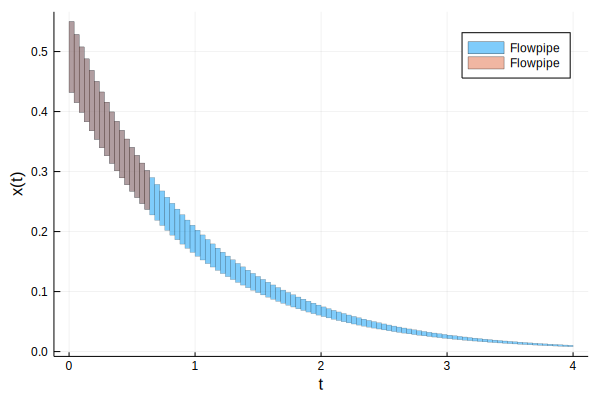

In [8]:
using ReachabilityAnalysis, Plots

# define the initial-value problem
# x' = Ax + Bu, x ∈ X, u ∈ U, x(0) ∈ X0
# x >= 0.3
probX = @ivp(x' = -x, x(0) ∈ 0.45 .. 0.55, x ∈ HalfSpace([-1.0], -0.3))

# solve it
sol = solve(probX, T=4.0)

# plot the solution, where the index 0 corresponds to the "time" variable
plot!(sol, vars=(0, 1), label="Flowpipe", xlab="t", ylab="x(t)", linewidth=0.3)

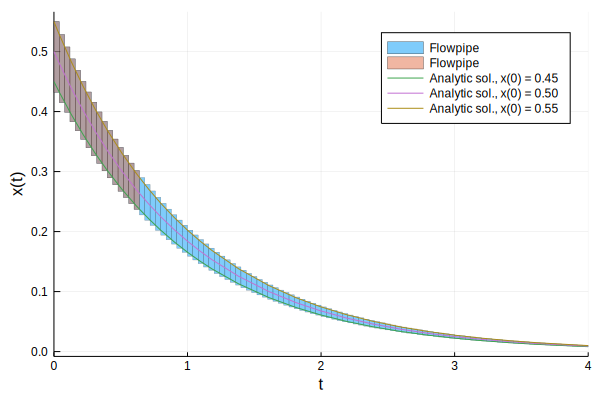

In [9]:
f(t, x0) = x0 * exp(-t)

plot!(t -> f(t, 0.45), xlims=(0, 4), label="Analytic sol., x(0) = 0.45")
plot!(t -> f(t, 0.50), xlims=(0, 4), label="Analytic sol., x(0) = 0.50")
plot!(t -> f(t, 0.55), xlims=(0, 4), label="Analytic sol., x(0) = 0.55")

- `ReachabilityAnalysis.jl` implements algorithms for:

   - Computing flowpipes for $x' = Ax + Bu$ with $x(0) \in X_0$ and $u \in U$ with $X_0$ and $U$ sets given by their support function, using state-of-the art methods (wrapping free, combination of zonotopes and support functions). Algorithms: `GLGM06`, `LGG09`, `BOX`, `INT`.
   - $x' = Ax + Bu$ where $A$ and $B$ are interval matrices using zonotopes, so the problem is still *linear*. Algorithm: `ASB07`.
   - Working on porting the hybrid systems stuff from the previous `Reachability.jl` package (https://arxiv.org/abs/1901.10736).
   - Flowpipes of nonlinear systems `x' = f(x, u, p, t)`. Algorithms `TMJets`. This works with `TaylorModels.validated_integ`, by converting the given initial states (often given as a LazySet) to an `IntervalArithmetic.IntervalBox`.

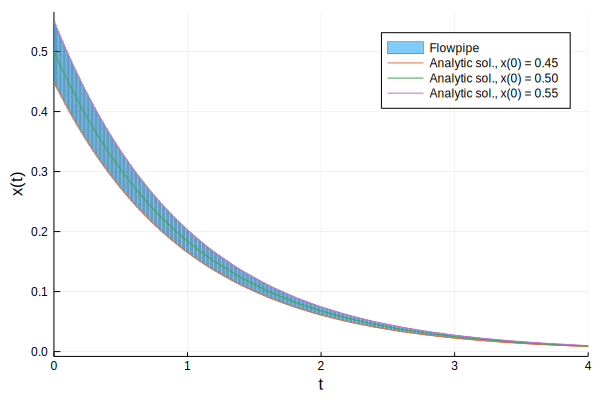

In [10]:
# change the step size
sol = solve(prob, T=4.0, alg=INT(δ=0.01))

# plot the solution, where the index 0 corresponds to the "time" variable
plot(sol, vars=(0, 1), label="Flowpipe", xlab="t", ylab="x(t)", linewidth=0.3)

f(t, x0) = x0 * exp(-t)

plot!(t -> f(t, 0.45), xlims=(0, 4), label="Analytic sol., x(0) = 0.45")
plot!(t -> f(t, 0.50), xlims=(0, 4), label="Analytic sol., x(0) = 0.50")
plot!(t -> f(t, 0.55), xlims=(0, 4), label="Analytic sol., x(0) = 0.55")

In [11]:
using BenchmarkTools

In [12]:
@btime solve($prob, T=4.0, alg=INT(δ=0.01));

  23.506 μs (29 allocations: 14.61 KiB)


Using `TMJets` algorithm:

In [60]:
@taylorize function exponential_decay!(dx, x, p, t)
    dx[1] = -x[1]
end

prob = @ivp(x'= exponential_decay!(x), dim:1, x(0) ∈ 0.45 .. 0.55)

solTM = solve(prob, T=4.0);
z = overapproximate(solTM, Zonotope);

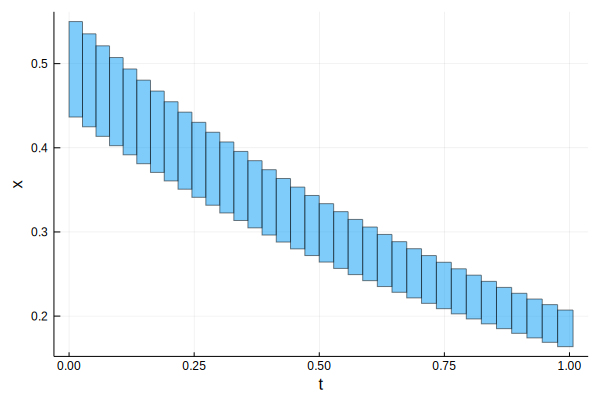

In [62]:
plot(z(0 .. 1.0), vars=(0, 1), xlab="t", ylab="x")

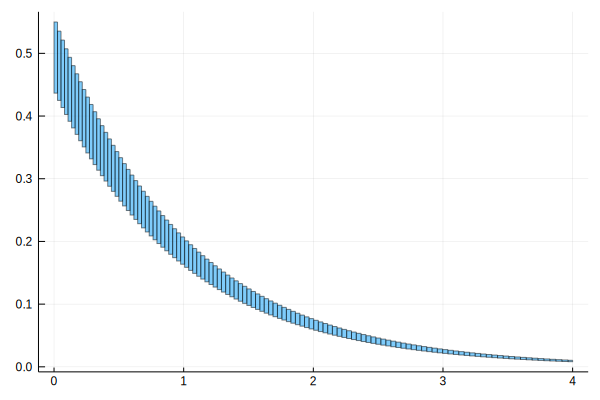

In [63]:
plot(z, vars=(0, 1))

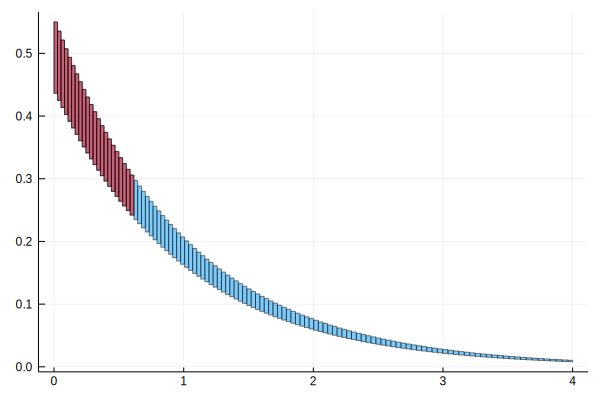

In [65]:
@taylorize function exponential_decay!(dx, x, p, t)
    dx[1] = -x[1]
end

H = HalfSpace([-1.0], -0.3)

prob = @ivp(x'= exponential_decay!(x), dim:1, x(0) ∈ 0.45 .. 0.55, x ∈ H)
solTM = solve(prob, T=4.0);

plot!(overapproximate(solTM, Zonotope), vars=(0, 1), color=:red)

Try enclosing the disjointness check with boxes:

In [66]:
solTM = solve(prob, T=4.0, intersction_method=ReachabilityAnalysis.BoxEnclosure());

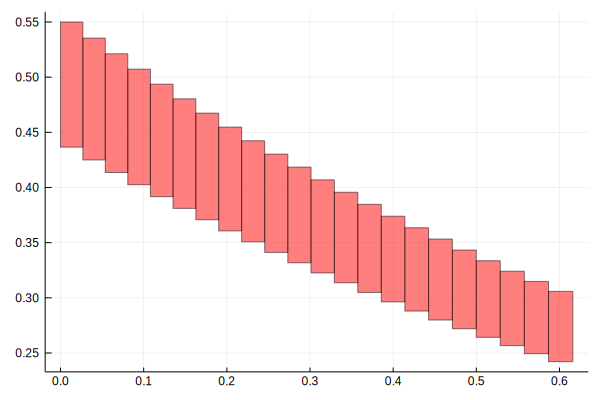

In [67]:
plot(overapproximate(solTM, Zonotope), vars=(0, 1), color=:red)

## New features in ReachabilityAnalysis

- Flowpipes have array-like interface and evaluation-like interface to evaluate at time points or at time intervals. 

In [ ]:
typeof(sol)

In [ ]:
sol[1]

In [ ]:
plot(sol, vars=(0, 1))

In [ ]:
using BenchmarkTools

In [ ]:
@btime solve()

- Conversion of *Taylor model flowpipes* to zonotopes for property verification and hybrid systems.

- Interface to split initial sets. Uses multithreading.

```julia
# start from sets X01 and X02
prob = @ivp(x' = f(x), x(0) ∈ [X01, X02])

# split the hyperrectangular set X0 into 12 equal boxes, with 2 cuts over direction
# x and 6 cuts over direction y
prob = @ivp(x' = f(x), x(0) ∈ split(X0, [2, 6]))
```